In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.models.load_utils import get_model
from oodeel.methods.mls import MLS
from oodeel.methods.dknn import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt


from oodeel.eval.experiment import TwoDSExperiment
from oodeel.datasets.load import dataset_load
from oodeel.eval.experiment import SingleDSExperiment



2022-08-16 16:06:05.596466: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-16 16:06:05.600283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 16:06:05.600301: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Two datasets experiment

In [3]:
model = get_model("../saved_models/mnist_model")

2022-08-16 16:06:25.846789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-16 16:06:25.846835: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-16 16:06:25.846866: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (B20212474): /proc/driver/nvidia/version does not exist
2022-08-16 16:06:25.847154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### MLS

313/313 [==============================] - 2s 6ms/step
0.9947957849999999


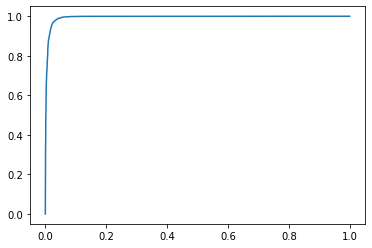

In [3]:

oodmodel = MLS(model)
expe = TwoDSExperiment(id_dataset_name="mnist", ood_dataset_name="fashion_mnist")
auroc, (tpc, fpc, tnc, fnc) = expe.run(oodmodel)

tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])

print(auroc)
plt.plot(fpr, tpr)
plt.show()


### DKNN

313/313 [==============================] - 2s 6ms/step
0.6690731950000001


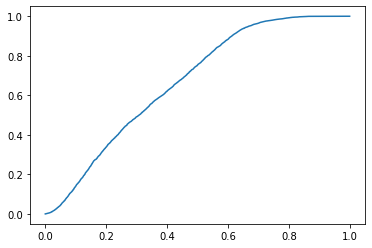

In [3]:
%autoreload 2

## This time need a dataset to fit KNN score
(x_train, y_train), (x_test, y_test) = dataset_load("mnist")

oodmodel = DKNN(model)
expe = TwoDSExperiment(id_dataset_name="mnist", ood_dataset_name="fashion_mnist")
auroc, (tpc, fpc, tnc, fnc) = expe.run(oodmodel, fit_dataset=x_train[:20000])

tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])

print(auroc)
plt.plot(fpr, tpr)
plt.show()

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def training_mnist(x_train, y_train, config=None):
    input_shape = (28, 28, 1)
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(config["num_classes"], activation="softmax"),
        ]
    )

    batch_size = 128
    epochs = 5

    # compile and fit
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)    

    return model


## MLS

Epoch 1/5
216/216 [==============================] - 10s 44ms/step - loss: 0.2420 - accuracy: 0.9301 - val_loss: 0.0477 - val_accuracy: 0.9876
Epoch 2/5
216/216 [==============================] - 9s 41ms/step - loss: 0.0593 - accuracy: 0.9812 - val_loss: 0.0303 - val_accuracy: 0.9925
Epoch 3/5
216/216 [==============================] - 9s 41ms/step - loss: 0.0431 - accuracy: 0.9867 - val_loss: 0.0257 - val_accuracy: 0.9935
Epoch 4/5
216/216 [==============================] - 9s 41ms/step - loss: 0.0342 - accuracy: 0.9900 - val_loss: 0.0203 - val_accuracy: 0.9951
Epoch 5/5
152/152 [==============================] - 1s 7ms/step
0.49325702876210853


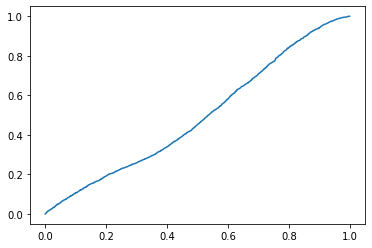

In [6]:
%autoreload 2

splits=[[0,1,2,3,4]]

oodmodel = MLS(model)
expe = SingleDSExperiment(dataset_name="mnist", training_func=training_mnist, config={"num_classes": 5})
results = expe.run(oodmodel, splits=splits)

auroc, (tpc, fpc, tnc, fnc) = results[str(splits[0])]

tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])

print(auroc)
plt.plot(fpr, tpr)
plt.show()

### DKNN

0.5017612211421474


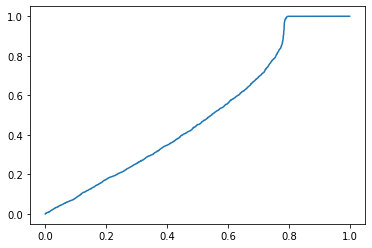

In [10]:
%autoreload 2

(x_train, y_train), (x_test, y_test) = dataset_load("mnist")

splits=[[0,1,2,3,4]]


oodmodel = DKNN(model)
expe = SingleDSExperiment(dataset_name="mnist", training_func=training_mnist, config={"num_classes": 5})
results = expe.run(oodmodel, splits=splits)

auroc, (tpc, fpc, tnc, fnc) = expe.results[str(splits[0])]
tpr = np.concatenate([[1.], tpc/(tpc + fnc), [0.]])
fpr = np.concatenate([[1.], fpc/(fpc + tnc), [0.]])

print(auroc)
plt.plot(fpr, tpr)
plt.show()